In [1]:
# %% [1] Imports + Warnings
"""
MODELO BAYESIANO MEJORADO - SERIE A
Integra métricas de Excel (IPO, IRD, TeamStats, PlayerStats)
Inspirado en el enfoque de Ramanujan: descomponer, no promediar
"""
import warnings
warnings.filterwarnings("ignore", message="PyTensor could not link to a BLAS")

from understatapi import UnderstatClient
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as pt

print("✓ Imports completados")

✓ Imports completados


In [4]:
# %% [2] Configuración General
LEAGUE = "Serie_A"
SEASONS = ["2022", "2023", "2024", "2025"]
TEST_SIZE = 50
RANDOM_SEED = 123

# Líneas de apuestas
TOTAL_SHOTS_LINES = list(np.arange(18.5, 28.5 + 1e-9, 1.0))
TEAM_SHOTS_LINES = list(np.arange(8.5, 16.5 + 1e-9, 1.0))

# Rutas CORREGIDAS - Usar r"" para rutas de Windows
PATH_INDICE_PERICOLOSITA = r"C:\Users\USER\SERIE_A_D1-D20_IndicePericolosità.xls"
PATH_TEAM_STATS = r"C:\Users\USER\SERIE_A_D1-D20_TeamStats (1).xls"
PATH_PLAYER_STATS = r"C:\Users\USER\SERIE_A_D1-D20_PlayerStats (1).xls"

print(f"Liga: {LEAGUE}")
print(f"Temporadas: {SEASONS}")
print(f"Test size: {TEST_SIZE}")

Liga: Serie_A
Temporadas: ['2022', '2023', '2024', '2025']
Test size: 50


In [6]:
# Instalar xlrd para leer archivos .xls
!pip install xlrd

In [7]:
# %% [3] Cargar datos de Excel - Índice de Pericolosidad
"""
CARGA DE MÉTRICAS IPO/IRD
- IPO: Índice de Pericolosidad Ofensiva (qué tan peligroso ataca)
- IRD: Índice de Riesgo Defensivo (qué tan vulnerable es defensivamente)
- Descomposición: Acción vs Palla Inattiva (como Ramanujan descompone en series)
"""

def load_indice_pericolosita(filepath):
    """Carga y procesa el archivo de Índice de Pericolosidad"""
    try:
        # Cargar hoja de medias por equipo
        df_medias = pd.read_excel(filepath, sheet_name='Medie Indice Pericolosita')
        
        # Limpiar: las columnas reales están en la fila 3
        headers = df_medias.iloc[3].tolist()
        df_medias = df_medias.iloc[4:24].copy()  # Filas 4-23 son los 20 equipos
        df_medias.columns = headers
        
        # Seleccionar columnas relevantes
        cols_keep = ['Squadra', 'Punti', 'Partite', 'IPO', 'IRD', 'IPO-IRD',
                     'IPO su Azione', 'IRD su Azione', 
                     'IPO su Palla Inattiva', 'IRD su Palla Inattiva',
                     'Media Reti Fatte', 'Media Reti Subite',
                     'Media % Possesso palla']
        
        # Filtrar columnas existentes
        cols_exist = [c for c in cols_keep if c in df_medias.columns]
        df_medias = df_medias[cols_exist].copy()
        
        # Convertir a numérico
        for col in df_medias.columns:
            if col != 'Squadra':
                df_medias[col] = pd.to_numeric(df_medias[col], errors='coerce')
        
        # Cargar datos por partido
        df_partidos = pd.read_excel(filepath, sheet_name='Indice per Partita')
        headers_p = df_partidos.iloc[3].tolist()
        df_partidos = df_partidos.iloc[4:].copy()
        df_partidos.columns = headers_p
        df_partidos = df_partidos.dropna(subset=['Giornata'])
        
        # Convertir tipos
        for col in df_partidos.columns:
            if col not in ['Squadra 1', 'Squadra 2', 'Esito']:
                df_partidos[col] = pd.to_numeric(df_partidos[col], errors='coerce')
        
        print(f"✓ Índice Pericolosidad cargado: {len(df_medias)} equipos, {len(df_partidos)} partidos")
        return df_medias, df_partidos
        
    except FileNotFoundError:
        print(f"⚠ Archivo no encontrado: {filepath}")
        return None, None

df_ipo_medias, df_ipo_partidos = load_indice_pericolosita(PATH_INDICE_PERICOLOSITA)

if df_ipo_medias is not None:
    print("\n--- Resumen IPO/IRD por equipo ---")
    print(df_ipo_medias[['Squadra', 'IPO', 'IRD', 'IPO-IRD']].head(10).to_string(index=False))

✓ Índice Pericolosidad cargado: 20 equipos, 196 partidos

--- Resumen IPO/IRD por equipo ---
   Squadra  IPO  IRD  IPO-IRD
     INTER 67.4 32.9     34.4
  JUVENTUS 57.8 31.2     26.6
    NAPOLI 50.9 33.0     17.9
     MILAN 56.4 39.5     16.9
  ATALANTA 50.7 35.7     15.0
      ROMA 50.3 39.8     10.5
      COMO 47.2 40.9      6.3
FIORENTINA 50.0 51.1     -1.1
     LAZIO 41.3 43.6     -2.3
    TORINO 41.2 45.4     -4.1


In [8]:
# %% [4] Cargar datos de Excel - Team Stats
"""
ESTADÍSTICAS DE EQUIPO (10 categorías)
Cada categoría es una "descomposición" del rendimiento total
Similar a cómo Ramanujan descompone sumas en componentes ortogonales
"""

def load_team_stats(filepath):
    """Carga todas las hojas de estadísticas de equipo"""
    try:
        xls = pd.ExcelFile(filepath)
        team_stats = {}
        
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet_name)
            
            # Headers en fila 3
            headers = df.iloc[3].tolist()
            df_clean = df.iloc[4:].copy()
            df_clean.columns = headers
            
            # Encontrar columna de equipo
            team_col = 'Squadra' if 'Squadra' in headers else None
            if team_col is None:
                for h in headers:
                    if h and 'Squadra' in str(h):
                        team_col = h
                        break
            
            if team_col:
                df_clean = df_clean.dropna(subset=[team_col])
                # Convertir numéricas
                for col in df_clean.columns:
                    if col != team_col and col != 'Gruppo':
                        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                
                team_stats[sheet_name] = df_clean
        
        print(f"✓ Team Stats cargado: {len(team_stats)} categorías")
        for name, df in team_stats.items():
            print(f"  - {name}: {len(df)} equipos, {len(df.columns)} métricas")
        
        return team_stats
        
    except FileNotFoundError:
        print(f"⚠ Archivo no encontrado: {filepath}")
        return None

team_stats = load_team_stats(PATH_TEAM_STATS)

✓ Team Stats cargado: 10 categorías
  - Tiri: 20 equipos, 30 métricas
  - Tiri Subiti: 20 equipos, 28 métricas
  - Palle Inattive: 20 equipos, 19 métricas
  - Palle Inattive Subite: 20 equipos, 19 métricas
  - Passaggi Chiave: 20 equipos, 31 métricas
  - Palle Laterali: 20 equipos, 19 métricas
  - Perde - Recupera: 20 equipos, 12 métricas
  - Duelli: 20 equipos, 27 métricas
  - Falli: 20 equipos, 14 métricas
  - Portieri: 20 equipos, 23 métricas


In [11]:
# %% [5] Cargar datos de Excel - Player Stats
"""
ESTADÍSTICAS DE JUGADORES
Los jugadores son como los "divisores" de Ramanujan
"""

def load_player_stats(filepath):
    """Carga estadísticas de jugadores y calcula métricas de dispersión por equipo"""
    try:
        xls = pd.ExcelFile(filepath)
        player_stats = {}
        team_dispersions = {}
        
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet_name)
            
            # Obtener headers y limpiar NaN
            headers = df.iloc[3].tolist()
            # Reemplazar NaN con nombres genéricos
            headers = [f"col_{i}" if pd.isna(h) or h is None else str(h) for i, h in enumerate(headers)]
            
            df_clean = df.iloc[4:].copy()
            df_clean.columns = headers
            
            # Buscar columna de equipo
            team_col = None
            for h in headers:
                if 'Squadra' in str(h):
                    team_col = h
                    break
            
            if team_col:
                df_clean = df_clean.dropna(subset=[team_col])
                player_stats[sheet_name] = df_clean
                
                # Seleccionar columnas numéricas válidas (excluyendo col_0, col_1, etc.)
                numeric_cols = []
                for col in headers:
                    if col != team_col and not col.startswith('col_') and 'Girone' not in col and 'Giocatore' not in col:
                        try:
                            converted = pd.to_numeric(df_clean[col], errors='coerce')
                            if converted.notna().sum() > 5:  # Al menos 5 valores válidos
                                numeric_cols.append(col)
                        except:
                            pass
                
                # Limitar a 8 columnas
                numeric_cols = numeric_cols[:8]
                
                if numeric_cols:
                    try:
                        df_numeric = df_clean[[team_col] + numeric_cols].copy()
                        for col in numeric_cols:
                            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
                        
                        dispersion = df_numeric.groupby(team_col)[numeric_cols].agg(['mean', 'std'])
                        # Aplanar nombres de columnas de forma segura
                        new_cols = []
                        for col_tuple in dispersion.columns:
                            new_cols.append(f"{col_tuple[0]}_{col_tuple[1]}")
                        dispersion.columns = new_cols
                        team_dispersions[sheet_name] = dispersion
                        print(f"  ✓ {sheet_name}: {len(numeric_cols)} métricas")
                    except Exception as e:
                        print(f"  ⚠ Error en {sheet_name}: {e}")
        
        print(f"\n✓ Player Stats cargado: {len(player_stats)} categorías")
        print(f"✓ Dispersiones calculadas: {len(team_dispersions)} tablas")
        
        return player_stats, team_dispersions
        
    except FileNotFoundError:
        print(f"⚠ Archivo no encontrado: {filepath}")
        return None, None
    except Exception as e:
        print(f"⚠ Error general: {e}")
        return None, None

player_stats, team_dispersions = load_player_stats(PATH_PLAYER_STATS)

  ✓ Tiri: 8 métricas
  ✓ Passaggi Chiave: 8 métricas
  ✓ Palle Laterali: 8 métricas
  ✓ Perde - Recupera: 8 métricas
  ✓ Duelli: 8 métricas
  ✓ Falli: 8 métricas
  ✓ Portieri: 8 métricas

✓ Player Stats cargado: 7 categorías
✓ Dispersiones calculadas: 7 tablas


In [12]:
# %% [6] Construir Features Compuestos por Equipo
"""
CONSTRUCCIÓN DE FEATURES AL ESTILO RAMANUJAN
No usamos métricas aisladas, construimos "índices compuestos" que capturan:
1. Término principal (media)
2. Oscilaciones (varianza, dispersión)
3. Colas (max, min, extremos)
"""

def build_team_features(df_ipo_medias, team_stats, team_dispersions):
    """
    Construye un DataFrame con features avanzados por equipo
    Combina IPO/IRD + TeamStats + dispersión de jugadores
    """
    
    if df_ipo_medias is None:
        print("⚠ No hay datos de IPO disponibles")
        return None
    
    # Base: IPO/IRD
    features = df_ipo_medias.copy()
    features = features.rename(columns={'Squadra': 'team'})
    features['team'] = features['team'].str.upper().str.strip()
    
    # Agregar TeamStats si disponible
    if team_stats is not None:
        
        # Tiros
        if 'Tiri' in team_stats:
            df_tiri = team_stats['Tiri'].copy()
            team_col = [c for c in df_tiri.columns if 'Squadra' in str(c)][0]
            df_tiri['team'] = df_tiri[team_col].str.upper().str.strip()
            
            cols_tiri = ['team', 'Tiri', 'Tiri in porta', 'Precisione', '% Realizzazione']
            cols_exist = [c for c in cols_tiri if c in df_tiri.columns]
            
            features = features.merge(
                df_tiri[cols_exist],
                on='team', how='left', suffixes=('', '_tiri')
            )
        
        # Pases clave
        if 'Passaggi Chiave' in team_stats:
            df_pass = team_stats['Passaggi Chiave'].copy()
            team_col = [c for c in df_pass.columns if 'Squadra' in str(c)][0]
            df_pass['team'] = df_pass[team_col].str.upper().str.strip()
            
            cols_pass = ['team', 'Passaggi Chiave + Assist', 'Assist', '% media possesso']
            cols_exist = [c for c in cols_pass if c in df_pass.columns]
            
            if len(cols_exist) > 1:
                features = features.merge(
                    df_pass[cols_exist],
                    on='team', how='left', suffixes=('', '_pass')
                )
        
        # Duelos
        if 'Duelli' in team_stats:
            df_duelli = team_stats['Duelli'].copy()
            team_col = [c for c in df_duelli.columns if 'Squadra' in str(c)][0]
            df_duelli['team'] = df_duelli[team_col].str.upper().str.strip()
            
            cols_duelli = ['team', 'Dribbling', '% dribbling vincenti', '% duelli vinti']
            cols_exist = [c for c in cols_duelli if c in df_duelli.columns]
            
            if len(cols_exist) > 1:
                features = features.merge(
                    df_duelli[cols_exist],
                    on='team', how='left', suffixes=('', '_duelli')
                )
        
        # Pérdidas/Recuperaciones
        if 'Perde - Recupera' in team_stats:
            df_pr = team_stats['Perde - Recupera'].copy()
            team_col = [c for c in df_pr.columns if 'Squadra' in str(c)][0]
            df_pr['team'] = df_pr[team_col].str.upper().str.strip()
            
            cols_pr = ['team', 'Perde palla', 'Recupera palla', 'Metà campo avversaria']
            cols_exist = [c for c in cols_pr if c in df_pr.columns]
            
            if len(cols_exist) > 1:
                features = features.merge(
                    df_pr[cols_exist],
                    on='team', how='left', suffixes=('', '_pr')
                )
    
    # Agregar dispersión de jugadores (varianza como señal de caos/estructura)
    if team_dispersions is not None and 'Tiri' in team_dispersions:
        df_disp = team_dispersions['Tiri'].reset_index()
        df_disp.columns = ['team'] + [f'player_{c}' for c in df_disp.columns[1:]]
        df_disp['team'] = df_disp['team'].str.upper().str.strip()
        
        # Solo columnas de std (varianza entre jugadores)
        std_cols = ['team'] + [c for c in df_disp.columns if '_std' in c][:5]
        
        features = features.merge(
            df_disp[std_cols],
            on='team', how='left'
        )
    
    print(f"✓ Features construidos: {len(features)} equipos, {len(features.columns)} variables")
    return features

team_features = build_team_features(df_ipo_medias, team_stats, team_dispersions)

if team_features is not None:
    print("\n--- Features por equipo (primeros 5) ---")
    print(team_features.head().to_string())

✓ Features construidos: 20 equipos, 31 variables

--- Features por equipo (primeros 5) ---
       team  Punti  Partite   IPO   IRD  IPO-IRD  IPO su Azione  IRD su Azione  IPO su Palla Inattiva  IRD su Palla Inattiva  Media Reti Fatte  Media Reti Subite  Media % Possesso palla   Tiri  Tiri in porta  Precisione  % Realizzazione  Passaggi Chiave + Assist  Assist  % media possesso  Dribbling  % dribbling vincenti  % duelli vinti  Perde palla  Recupera palla  Metà campo avversaria  player_n°_std  player_Anno _std  player_Età_std  player_Partite_std  player_Titolare_std
0     INTER     43       19  67.4  32.9     34.4           52.4           25.0                   15.0                    7.9               2.2                0.9                    56.9  298.0          155.0       0.520            0.134                     746.0   238.0              56.9      215.0                 0.572           0.508       1177.0          1279.0                  419.0     118.667142          4.475861       

In [13]:
# %% [7] Descargar partidos de Understat
"""
DATOS DE UNDERSTAT
Combinaremos estos con nuestros features de Excel
"""

def get_league_matches(league: str, seasons: list[str]):
    all_matches = []
    with UnderstatClient() as us:
        for season in seasons:
            matches = us.league(league=league).get_match_data(season=season)
            all_matches.extend(matches)
    return all_matches

print("Descargando partidos de Understat...")
raw_matches = get_league_matches(LEAGUE, SEASONS)
print(f"Total de partidos (incluye no finalizados): {len(raw_matches)}")

raw_matches = [m for m in raw_matches if m.get("isResult")]
print(f"Partidos con resultado: {len(raw_matches)}")

Descargando partidos de Understat...
Total de partidos (incluye no finalizados): 1520
Partidos con resultado: 1346


In [14]:
# %% [8] Descargar tiros por partido
"""
TIROS POR PARTIDO
Variable objetivo del modelo
"""

def get_match_shot_counts(match_id: str, us: UnderstatClient):
    data = us.match(match=str(match_id)).get_shot_data()
    h_shots = len(data.get("h", []))
    a_shots = len(data.get("a", []))
    return int(h_shots), int(a_shots)

def format_fixtures_shots(matches: list[dict]) -> pd.DataFrame:
    rows = []
    bad = 0
    with UnderstatClient() as us:
        for m in tqdm(matches, desc="Descargando tiros por partido"):
            try:
                match_id = m["id"]
                h_shots, a_shots = get_match_shot_counts(match_id, us)
                rows.append({
                    "date": m["datetime"],
                    "home_team": m["h"]["title"],
                    "away_team": m["a"]["title"],
                    "ys1": h_shots,
                    "ys2": a_shots,
                })
            except Exception:
                bad += 1

    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    print(f"Partidos fallidos (sin tiros): {bad}")
    return df

fixtures = format_fixtures_shots(raw_matches)
print(f"Partidos jugados con tiros: {len(fixtures)}")
fixtures.head()

Descargando tiros por partido:   0%|          | 0/1346 [00:00<?, ?it/s]

Partidos fallidos (sin tiros): 0
Partidos jugados con tiros: 1346


,date,home_team,away_team,ys1,ys2
0,2022-08-13 16:30:00,AC Milan,Udinese,14,9
1,2022-08-13 16:30:00,Sampdoria,Atalanta,11,9
2,2022-08-13 18:45:00,Monza,Torino,15,13
3,2022-08-13 18:45:00,Lecce,Inter,10,19
4,2022-08-14 16:30:00,Lazio,Bologna,9,12


In [15]:
# %% [9] Indexación de equipos + Merge con Features Excel
"""
MERGE DE DATOS
Unimos los datos de Understat con nuestros features de Excel
"""

teams = (
    pd.concat([
        fixtures[["home_team"]].rename(columns={"home_team": "team"}),
        fixtures[["away_team"]].rename(columns={"away_team": "team"}),
    ], ignore_index=True)
    .drop_duplicates()
    .sort_values("team")
    .reset_index(drop=True)
    .assign(team_index=lambda x: np.arange(len(x)))
)

n_teams = len(teams)
print(f"Equipos en Understat: {n_teams}")

# Normalizar nombres para merge
teams['team_upper'] = teams['team'].str.upper().str.strip()

# Merge con features de Excel
if team_features is not None:
    teams = teams.merge(
        team_features,
        left_on='team_upper',
        right_on='team',
        how='left',
        suffixes=('', '_excel')
    )
    print(f"✓ Features de Excel mergeados")

print(teams[['team', 'team_index']].head(10).to_string(index=False))

Equipos en Understat: 27
✓ Features de Excel mergeados
      team  team_index
  AC Milan           0
  Atalanta           1
   Bologna           2
  Cagliari           3
      Como           4
 Cremonese           5
    Empoli           6
Fiorentina           7
 Frosinone           8
     Genoa           9


In [16]:
# %% [10] Construir DataFrame principal
"""
DATAFRAME PRINCIPAL
Con índices de equipo y preparado para features
"""

df = (
    fixtures
    .merge(teams[['team', 'team_index']], left_on="home_team", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .merge(teams[['team', 'team_index']], left_on="away_team", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("date")
    .reset_index(drop=True)
)

print(f"DataFrame principal: {len(df)} partidos")
df.head()

DataFrame principal: 1346 partidos


,date,home_team,away_team,ys1,ys2,hg,ag
0,2022-08-13 16:30:00,AC Milan,Udinese,14,9,0,24
1,2022-08-13 16:30:00,Sampdoria,Atalanta,11,9,20,1
2,2022-08-13 18:45:00,Monza,Torino,15,13,14,23
3,2022-08-13 18:45:00,Lecce,Inter,10,19,13,10
4,2022-08-14 16:30:00,Lazio,Bologna,9,12,12,2


In [17]:
# %% [11] Features EWMA de forma reciente (shots)
"""
FORMA RECIENTE - EWMA
Media móvil exponencial de tiros a favor/en contra
"""

def add_ewma_forms(df_all: pd.DataFrame, span: int = 8) -> pd.DataFrame:
    df0 = df_all.copy().sort_values("date").reset_index(drop=True)
    df0["match_id_tmp"] = np.arange(len(df0), dtype=int)

    home_long = df0[["match_id_tmp","date","home_team","away_team","ys1","ys2"]].copy()
    away_long = df0[["match_id_tmp","date","home_team","away_team","ys1","ys2"]].copy()

    home_long["team"] = home_long["home_team"]
    home_long["shots_for"] = home_long["ys1"]
    home_long["shots_against"] = home_long["ys2"]
    home_long["is_home"] = 1

    away_long["team"] = away_long["away_team"]
    away_long["shots_for"] = away_long["ys2"]
    away_long["shots_against"] = away_long["ys1"]
    away_long["is_home"] = 0

    long = pd.concat(
        [home_long[["match_id_tmp","date","team","shots_for","shots_against","is_home"]],
         away_long[["match_id_tmp","date","team","shots_for","shots_against","is_home"]]],
        ignore_index=True
    ).sort_values(["team","date","match_id_tmp"]).reset_index(drop=True)

    long["shots_for_shift"] = long.groupby("team")["shots_for"].shift(1)
    long["shots_against_shift"] = long.groupby("team")["shots_against"].shift(1)

    long["for_ewma"] = long.groupby("team")["shots_for_shift"].transform(
        lambda s: s.ewm(span=span, adjust=False).mean()
    )
    long["against_ewma"] = long.groupby("team")["shots_against_shift"].transform(
        lambda s: s.ewm(span=span, adjust=False).mean()
    )

    home_feats = long[long["is_home"]==1][["match_id_tmp","for_ewma","against_ewma"]].rename(
        columns={"for_ewma":"home_for_form","against_ewma":"home_against_form"}
    )
    away_feats = long[long["is_home"]==0][["match_id_tmp","for_ewma","against_ewma"]].rename(
        columns={"for_ewma":"away_for_form","against_ewma":"away_against_form"}
    )

    out = df0.merge(home_feats, on="match_id_tmp", how="left").merge(away_feats, on="match_id_tmp", how="left")

    for c in ["home_for_form","home_against_form","away_for_form","away_against_form"]:
        out[c] = out[c].fillna(out[c].mean())

    for c in ["home_for_form","home_against_form","away_for_form","away_against_form"]:
        mu, sd = out[c].mean(), out[c].std() + 1e-9
        out[c] = (out[c] - mu) / sd

    return out.drop(columns=["match_id_tmp"])

df = add_ewma_forms(df, span=8)
print("✓ EWMA forms agregadas")
df.head()


✓ EWMA forms agregadas


,date,home_team,away_team,ys1,ys2,hg,ag,home_for_form,home_against_form,away_for_form,away_against_form
0,2022-08-13 16:30:00,AC Milan,Udinese,14,9,0,24,0.0,0.0,6.839217e-16,-7.041529e-16
1,2022-08-13 16:30:00,Sampdoria,Atalanta,11,9,20,1,0.0,0.0,6.839217e-16,-7.041529e-16
2,2022-08-13 18:45:00,Monza,Torino,15,13,14,23,0.0,0.0,6.839217e-16,-7.041529e-16
3,2022-08-13 18:45:00,Lecce,Inter,10,19,13,10,0.0,0.0,6.839217e-16,-7.041529e-16
4,2022-08-14 16:30:00,Lazio,Bologna,9,12,12,2,0.0,0.0,6.839217e-16,-7.041529e-16


In [18]:
# %% [12] Features de "concede tiros" (estilo defensivo)
"""
CONCEDE FEATURES
Captura el estilo defensivo: ¿el equipo permite muchos tiros?
"""

def add_concede_features(df_all: pd.DataFrame, span: int = 10) -> pd.DataFrame:
    df0 = df_all.copy().sort_values("date").reset_index(drop=True)
    df0["match_id_tmp"] = np.arange(len(df0), dtype=int)

    home_long = df0[["match_id_tmp","date","home_team","away_team","ys1","ys2"]].copy()
    away_long = df0[["match_id_tmp","date","home_team","away_team","ys1","ys2"]].copy()

    home_long["team"] = home_long["home_team"]
    home_long["shots_against"] = home_long["ys2"]
    home_long["is_home"] = 1

    away_long["team"] = away_long["away_team"]
    away_long["shots_against"] = away_long["ys1"]
    away_long["is_home"] = 0

    long = pd.concat(
        [home_long[["match_id_tmp","date","team","shots_against","is_home"]],
         away_long[["match_id_tmp","date","team","shots_against","is_home"]]],
        ignore_index=True
    ).sort_values(["team","date","match_id_tmp"]).reset_index(drop=True)

    long["sa_shift"] = long.groupby("team")["shots_against"].shift(1)
    long["concede_ewma"] = long.groupby("team")["sa_shift"].transform(
        lambda s: s.ewm(span=span, adjust=False).mean()
    )

    home_feats = long[long["is_home"]==1][["match_id_tmp","concede_ewma"]].rename(columns={"concede_ewma":"home_concede"})
    away_feats = long[long["is_home"]==0][["match_id_tmp","concede_ewma"]].rename(columns={"concede_ewma":"away_concede"})

    out = df0.merge(home_feats, on="match_id_tmp", how="left").merge(away_feats, on="match_id_tmp", how="left")

    out["home_concede"] = out["home_concede"].fillna(out["home_concede"].mean())
    out["away_concede"] = out["away_concede"].fillna(out["away_concede"].mean())

    for c in ["home_concede","away_concede"]:
        mu, sd = out[c].mean(), out[c].std() + 1e-9
        out[c] = (out[c] - mu) / sd

    return out.drop(columns=["match_id_tmp"])

df = add_concede_features(df, span=10)
print("✓ Concede features agregadas")

✓ Concede features agregadas


In [20]:
# %% [13] NUEVO: Agregar Features IPO/IRD por partido
"""
FEATURES IPO/IRD (ESTILO RAMANUJAN)
Estos son índices compuestos que capturan la "peligrosidad real"
"""

def add_ipo_ird_features(df_all: pd.DataFrame, teams_df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega IPO, IRD y métricas derivadas como features por partido
    """
    df0 = df_all.copy()
    
    # Verificar columnas disponibles
    ipo_cols = ['IPO', 'IRD', 'IPO-IRD']
    available_cols = [c for c in ipo_cols if c in teams_df.columns]
    
    if not available_cols:
        print("⚠ No hay columnas IPO/IRD disponibles")
        return df0
    
    print(f"Agregando features IPO/IRD: {available_cols}")
    
    # Crear diccionario de lookup por equipo (solo valores numéricos)
    teams_lookup_upper = {}
    for _, row in teams_df.iterrows():
        team_name = str(row.get('team', '')).upper().strip()
        if team_name:
            teams_lookup_upper[team_name] = {}
            for col in available_cols:
                val = row.get(col)
                # Solo guardar si es numérico
                if pd.notna(val):
                    try:
                        teams_lookup_upper[team_name][col] = float(val)
                    except (ValueError, TypeError):
                        pass
    
    print(f"  Equipos con datos IPO/IRD: {len(teams_lookup_upper)}")
    
    # Agregar features para home y away
    for col in available_cols:
        col_clean = col.replace(' ', '_').replace('-', '_')
        
        # Home team
        home_vals = []
        for team in df0['home_team']:
            team_upper = str(team).upper().strip()
            val = teams_lookup_upper.get(team_upper, {}).get(col, np.nan)
            home_vals.append(val)
        df0[f'home_{col_clean}'] = home_vals
        
        # Away team
        away_vals = []
        for team in df0['away_team']:
            team_upper = str(team).upper().strip()
            val = teams_lookup_upper.get(team_upper, {}).get(col, np.nan)
            away_vals.append(val)
        df0[f'away_{col_clean}'] = away_vals
    
    # Convertir a numérico explícitamente
    for col in available_cols:
        col_clean = col.replace(' ', '_').replace('-', '_')
        df0[f'home_{col_clean}'] = pd.to_numeric(df0[f'home_{col_clean}'], errors='coerce')
        df0[f'away_{col_clean}'] = pd.to_numeric(df0[f'away_{col_clean}'], errors='coerce')
    
    # Crear features derivados solo si tenemos IPO e IRD
    if 'IPO' in available_cols and 'IRD' in available_cols:
        # Diferencia de peligrosidad
        df0['ipo_diff'] = df0['home_IPO'] - df0['away_IPO']
        df0['ird_diff'] = df0['home_IRD'] - df0['away_IRD']
        
        # Matchup: IPO atacante vs IRD defensor
        df0['home_attack_vs_away_def'] = df0['home_IPO'] - df0['away_IRD']
        df0['away_attack_vs_home_def'] = df0['away_IPO'] - df0['home_IRD']
        
        # Índice de partido "caótico" (ambos atacan mucho)
        df0['chaos_index'] = df0['home_IPO'] + df0['away_IPO']
        
        # Índice de partido "cerrado" (ambos defienden bien)
        df0['closed_index'] = df0['home_IRD'] + df0['away_IRD']
    
    # Estandarizar los nuevos features numéricos
    new_numeric_cols = ['ipo_diff', 'ird_diff', 'home_attack_vs_away_def', 
                        'away_attack_vs_home_def', 'chaos_index', 'closed_index']
    
    for col in new_numeric_cols:
        if col in df0.columns:
            # Asegurar que es numérico
            df0[col] = pd.to_numeric(df0[col], errors='coerce')
            
            if df0[col].notna().sum() > 0:
                mu = df0[col].mean()
                sd = df0[col].std()
                if sd > 0:
                    df0[f'{col}_std'] = (df0[col].fillna(mu) - mu) / sd
                else:
                    df0[f'{col}_std'] = 0.0
            else:
                df0[f'{col}_std'] = 0.0
    
    n_features = len([c for c in df0.columns if '_std' in c])
    n_matched = df0['home_IPO'].notna().sum() if 'home_IPO' in df0.columns else 0
    print(f"✓ {n_features} features IPO/IRD estandarizados")
    print(f"✓ Partidos con datos IPO: {n_matched} de {len(df0)}")
    
    return df0

# Solo agregar si tenemos los datos
if team_features is not None and 'IPO' in team_features.columns:
    df = add_ipo_ird_features(df, team_features)
else:
    print("⚠ Saltando features IPO/IRD (datos no disponibles)")

print(f"\nColumnas en df: {len(df.columns)}")
print(df[['home_team', 'away_team', 'ys1', 'ys2']].tail(5))

Agregando features IPO/IRD: ['IPO', 'IRD', 'IPO-IRD']
  Equipos con datos IPO/IRD: 20
✓ 6 features IPO/IRD estandarizados
✓ Partidos con datos IPO: 1021 de 1346

Columnas en df: 31
              home_team   away_team  ys1  ys2
1341            Udinese       Inter    5   14
1342             Napoli    Sassuolo   11   21
1343           Cagliari    Juventus    3   21
1344  Parma Calcio 1913       Genoa   14   11
1345            Bologna  Fiorentina   19   11


In [21]:
# %% [14] NUEVO: Features de dispersión de jugadores (varianza como señal)
"""
DISPERSIÓN DE JUGADORES (CONCEPTO RAMANUJAN)
La varianza entre jugadores NO es ruido - es información
Un equipo con alta varianza tiene "colas pesadas" (jugadores estrella vs suplentes)
"""

def add_player_dispersion_features(df_all: pd.DataFrame, teams_df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega métricas de dispersión (varianza entre jugadores) por equipo
    """
    df0 = df_all.copy()
    
    # Buscar columnas de dispersión
    disp_cols = [c for c in teams_df.columns if 'player_' in c and '_std' in c]
    
    if not disp_cols:
        print("⚠ No hay columnas de dispersión de jugadores")
        return df0
    
    print(f"Agregando {len(disp_cols)} features de dispersión de jugadores")
    
    # Lookup
    teams_lookup = teams_df.set_index('team')[disp_cols].to_dict('index')
    teams_lookup_upper = {str(k).upper().strip(): v for k, v in teams_lookup.items()}
    
    for col in disp_cols[:5]:  # Top 5 para no sobrecargar
        col_clean = col.replace(' ', '_')
        
        df0[f'home_{col_clean}'] = df0['home_team'].apply(
            lambda x: teams_lookup_upper.get(str(x).upper().strip(), {}).get(col, np.nan)
        )
        df0[f'away_{col_clean}'] = df0['away_team'].apply(
            lambda x: teams_lookup_upper.get(str(x).upper().strip(), {}).get(col, np.nan)
        )
    
    # Estandarizar
    new_cols = [c for c in df0.columns if 'player_' in c]
    for col in new_cols:
        if df0[col].notna().any():
            mu, sd = df0[col].mean(), df0[col].std() + 1e-9
            df0[col] = (df0[col].fillna(mu) - mu) / sd
    
    print(f"✓ Features de dispersión agregados")
    return df0

if team_features is not None:
    disp_cols = [c for c in team_features.columns if 'player_' in c]
    if disp_cols:
        df = add_player_dispersion_features(df, team_features)

Agregando 5 features de dispersión de jugadores
✓ Features de dispersión agregados


In [22]:
# %% [15] Train/Test Split + Matrices para el modelo
"""
PREPARACIÓN DE DATOS PARA PYMC
"""

train = df.iloc[:-TEST_SIZE].copy()
test = df.iloc[-TEST_SIZE:].copy()

shots_home_obs = train["ys1"].values.astype(int)
shots_away_obs = train["ys2"].values.astype(int)

home_team = train["hg"].values.astype(int)
away_team = train["ag"].values.astype(int)

# Features base
X_home_for = train["home_for_form"].values
X_home_against = train["home_against_form"].values
X_away_for = train["away_for_form"].values
X_away_against = train["away_against_form"].values

home_concede = train["home_concede"].values
away_concede = train["away_concede"].values

# Features IPO/IRD (si disponibles)
ipo_features = []
ipo_feature_names = []

for col in ['ipo_diff_std', 'ird_diff_std', 'chaos_index_std', 'closed_index_std',
            'home_attack_vs_away_def_std', 'away_attack_vs_home_def_std']:
    if col in train.columns:
        ipo_features.append(train[col].fillna(0).values)
        ipo_feature_names.append(col)

# Construir matriz X_reg (features para estados latentes)
base_features = [X_home_for, X_home_against, X_away_for, X_away_against, home_concede, away_concede]
all_features = base_features + ipo_features

X_reg = np.column_stack(all_features).astype(float)

n_matches = len(train)
n_features = X_reg.shape[1]

print(f"Train: {n_matches} | Test: {len(test)} | Features: {n_features}")
print(f"Features base: 6")
print(f"Features IPO/IRD: {len(ipo_features)} -> {ipo_feature_names}")

Train: 1296 | Test: 50 | Features: 12
Features base: 6
Features IPO/IRD: 6 -> ['ipo_diff_std', 'ird_diff_std', 'chaos_index_std', 'closed_index_std', 'home_attack_vs_away_def_std', 'away_attack_vs_home_def_std']


In [23]:
# %% [16] Modelo Bayesiano Mejorado con IPO/IRD
"""
MODELO BAYESIANO ESTILO RAMANUJAN
- Descomponemos en: término principal (ratings) + oscilaciones (estados latentes) + colas (NB)
- Los features IPO/IRD actúan como "transformación de Bessel" que captura estructura oculta
"""

with pm.Model() as model:
    # ============================================================
    # 1) TÉRMINO PRINCIPAL: Base + Localía
    # ============================================================
    beta0 = pm.Normal("beta0", 0.0, 1.0)
    home_adv = pm.Normal("home_adv", 0.0, 0.3)

    # ============================================================
    # 2) RATINGS POR EQUIPO (ataque/defensa) - centrados
    # ============================================================
    sigma_att = pm.HalfNormal("sigma_att", 0.35)
    sigma_def = pm.HalfNormal("sigma_def", 0.35)

    att_star = pm.Normal("att_star", 0.0, sigma=sigma_att, shape=n_teams)
    def_star = pm.Normal("def_star", 0.0, sigma=sigma_def, shape=n_teams)

    att = pm.Deterministic("att", att_star - pt.mean(att_star))
    deff = pm.Deterministic("deff", def_star - pt.mean(def_star))

    # ============================================================
    # 3) FORMA RECIENTE (corrección temporal)
    # ============================================================
    b_for = pm.Normal("b_for", 0.0, 0.15)
    b_against = pm.Normal("b_against", 0.0, 0.15)

    form_home = b_for * X_home_for + b_against * X_home_against
    form_away = b_for * X_away_for + b_against * X_away_against

    # ============================================================
    # 4) NUEVO: Coeficientes IPO/IRD (si disponibles)
    # ============================================================
    if len(ipo_features) > 0:
        # Coeficientes para features IPO/IRD
        b_ipo = pm.Normal("b_ipo", 0.0, 0.2, shape=len(ipo_features))
        
        # Efecto IPO/IRD
        X_ipo = np.column_stack(ipo_features).astype(float)
        ipo_effect = pm.math.dot(X_ipo, b_ipo)
    else:
        ipo_effect = 0.0

    # ============================================================
    # 5) OVERDISPERSION (colas pesadas) - Negative Binomial
    # ============================================================
    alpha = pm.HalfNormal("alpha", 1.0)

    # ============================================================
    # 6) ESTADOS LATENTES SUAVES (pace + tilt)
    #    Inspirado en descomposición de Ramanujan:
    #    - pace: componente simétrica (afecta ambos)
    #    - tilt: componente asimétrica (favorece a uno)
    # ============================================================

    # ---------- Pace States (lento/normal/caótico) ----------
    W = pm.Normal("W", 0.0, 0.6, shape=(n_features, 3))
    logits_pace = pm.math.dot(X_reg, W)
    w_match = pm.Deterministic("w_match", pm.math.softmax(logits_pace))
    
    pace_mu = pm.Normal("pace_mu", mu=[-0.25, 0.0, 0.25], sigma=0.25, shape=3)
    pace = pm.Deterministic("pace", pm.math.sum(w_match * pace_mu, axis=1))

    # ---------- Tilt States (away/neutral/home) ----------
    V = pm.Normal("V", 0.0, 0.6, shape=(n_features, 3))
    logits_tilt = pm.math.dot(X_reg, V)
    v_match = pm.Deterministic("v_match", pm.math.softmax(logits_tilt))
    
    tilt_mu = pm.Normal("tilt_mu", mu=[-0.20, 0.0, 0.20], sigma=0.20, shape=3)
    tilt = pm.Deterministic("tilt", pm.math.sum(v_match * tilt_mu, axis=1))

    # ============================================================
    # 7) MEDIAS FINALES con direccionalidad
    # ============================================================
    mu_home = pt.exp(
        beta0 + home_adv 
        + att[home_team] - deff[away_team] 
        + pace + tilt 
        + form_home 
        + ipo_effect
    )
    
    mu_away = pt.exp(
        beta0 
        + att[away_team] - deff[home_team] 
        + pace - tilt 
        + form_away 
        + ipo_effect
    )

    # ============================================================
    # 8) LIKELIHOOD - Negative Binomial
    # ============================================================
    pm.NegativeBinomial("home_shots", mu=mu_home, alpha=alpha, observed=shots_home_obs)
    pm.NegativeBinomial("away_shots", mu=mu_away, alpha=alpha, observed=shots_away_obs)

print("✓ Modelo construido")
print(model)


✓ Modelo construido


In [24]:
# %% [17] Sampling del modelo
"""
INFERENCIA BAYESIANA
"""

print("Iniciando sampling...")
with model:
    trace = pm.sample(
        draws=2000,
        tune=1500,
        chains=4,
        cores=4,
        target_accept=0.92,
        random_seed=RANDOM_SEED,
        progressbar=True
    )

print("✓ Sampling completado")

Iniciando sampling...


Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, home_adv, sigma_att, sigma_def, att_star, def_star, b_for, b_against, b_ipo, alpha, W, pace_mu, V, tilt_mu]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 504 seconds.


✓ Sampling completado


In [25]:
# %% [18] Diagnóstico del modelo
"""
DIAGNÓSTICO Y RESUMEN
"""

var_names_base = [
    "beta0", "home_adv", "sigma_att", "sigma_def", "alpha",
    "b_for", "b_against", "pace_mu", "tilt_mu", "W", "V"
]

# Agregar b_ipo si existe
if len(ipo_features) > 0:
    var_names_base.append("b_ipo")

summary = az.summary(trace, var_names=var_names_base, round_to=3)
print(summary)

# Probabilidades de estados
w_mean = trace.posterior["w_match"].mean(dim=("chain", "draw")).values
v_mean = trace.posterior["v_match"].mean(dim=("chain", "draw")).values

print(f"\nPace states promedio: lento={w_mean[:,0].mean():.1%} | normal={w_mean[:,1].mean():.1%} | caótico={w_mean[:,2].mean():.1%}")
print(f"Tilt states promedio: away={v_mean[:,0].mean():.1%} | neutral={v_mean[:,1].mean():.1%} | home={v_mean[:,2].mean():.1%}")

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0       2.435  0.014   2.410    2.460      0.000    0.000  4059.481   
home_adv    0.184  0.016   0.154    0.214      0.000    0.000  6333.910   
sigma_att   0.098  0.022   0.061    0.141      0.000    0.000  2468.692   
sigma_def   0.140  0.024   0.100    0.186      0.000    0.000  4648.478   
alpha      12.641  0.502  11.708   13.577      0.005    0.006  8779.338   
...           ...    ...     ...      ...        ...      ...       ...   
b_ipo[1]   -0.008  0.095  -0.182    0.176      0.002    0.001  2576.443   
b_ipo[2]    0.030  0.112  -0.173    0.249      0.002    0.001  3284.697   
b_ipo[3]    0.036  0.095  -0.139    0.221      0.002    0.001  3254.531   
b_ipo[4]    0.001  0.143  -0.266    0.274      0.003    0.002  2931.726   
b_ipo[5]    0.004  0.139  -0.258    0.259      0.003    0.002  2834.029   

           ess_tail  r_hat  
beta0      5270.351  1.001  
home_adv   5724.192  1.000  
sigma_att  3

In [26]:
# %% [19] Coeficientes IPO/IRD (si disponibles)
"""
ANÁLISIS DE COEFICIENTES IPO/IRD
"""

if len(ipo_features) > 0:
    b_ipo_samples = trace.posterior["b_ipo"].values.reshape(-1, len(ipo_features))
    
    print("\n--- Coeficientes IPO/IRD ---")
    for i, name in enumerate(ipo_feature_names):
        mean_val = b_ipo_samples[:, i].mean()
        std_val = b_ipo_samples[:, i].std()
        p_positive = (b_ipo_samples[:, i] > 0).mean()
        print(f"{name}: mean={mean_val:.4f}, std={std_val:.4f}, P(>0)={p_positive:.1%}")


--- Coeficientes IPO/IRD ---
ipo_diff_std: mean=-0.0053, std=0.1120, P(>0)=47.7%
ird_diff_std: mean=-0.0077, std=0.0952, P(>0)=46.3%
chaos_index_std: mean=0.0299, std=0.1116, P(>0)=60.4%
closed_index_std: mean=0.0361, std=0.0953, P(>0)=65.2%
home_attack_vs_away_def_std: mean=0.0007, std=0.1429, P(>0)=50.6%
away_attack_vs_home_def_std: mean=0.0040, std=0.1386, P(>0)=51.3%


In [27]:
# %% [20] Top partidos caóticos
"""
PARTIDOS MÁS CAÓTICOS (según el modelo)
"""

p_chaos = w_mean[:, 2]
top_idx = np.argsort(-p_chaos)[:10]

print("\n--- Top 10 partidos más caóticos ---")
display_df = train.iloc[top_idx][["date", "home_team", "away_team", "ys1", "ys2"]].copy()
display_df["p_chaos"] = p_chaos[top_idx]
print(display_df.to_string(index=False))


--- Top 10 partidos más caóticos ---
               date  home_team  away_team  ys1  ys2  p_chaos
2022-08-22 16:30:00       Roma  Cremonese   27   14 0.038185
2022-08-21 18:45:00    Bologna     Verona   17   19 0.034196
2022-08-27 16:30:00  Cremonese     Torino   16   14 0.023115
2022-08-30 18:45:00      Inter  Cremonese   18   11 0.014560
2022-08-28 18:45:00 Fiorentina     Napoli   10   13 0.013895
2022-09-04 10:30:00  Cremonese   Sassuolo   10   17 0.005765
2022-08-28 16:30:00     Verona   Atalanta   14   15 0.003449
2022-08-21 16:30:00     Empoli Fiorentina    4   19 0.002897
2022-08-21 16:30:00     Napoli      Monza   22    4 0.002715
2023-03-19 19:45:00      Inter   Juventus   18    7 0.002320


In [28]:
# %% [21] Funciones de predicción
"""
FUNCIONES AUXILIARES PARA PREDICCIÓN
"""

def _gamma_poisson_nb_rng(mu, alpha, rng):
    mu = np.asarray(mu)
    alpha = np.asarray(alpha)
    lam = rng.gamma(shape=alpha, scale=mu/alpha)
    return rng.poisson(lam)

def _ou_probs(samples, line):
    k = int(np.floor(line))
    under = np.mean(samples <= k)
    over = 1.0 - under
    return float(over), float(under)

def _get_team_id(teams_df, name):
    # Normalizar nombre
    name_upper = str(name).upper().strip()
    matches = teams_df[teams_df["team"].str.upper().str.strip() == name_upper]
    if len(matches) == 0:
        raise ValueError(f"Equipo no encontrado: {name}")
    return int(matches["team_index"].iat[0])

def _last_team_row(df_all, team_name):
    return df_all[(df_all["home_team"]==team_name) | (df_all["away_team"]==team_name)].iloc[-1]

def _team_last_forms_and_concede(df_all, team_name):
    sub = _last_team_row(df_all, team_name)
    if sub["home_team"] == team_name:
        f_for = float(sub["home_for_form"])
        f_ag = float(sub["home_against_form"])
        concede = float(sub["home_concede"])
    else:
        f_for = float(sub["away_for_form"])
        f_ag = float(sub["away_against_form"])
        concede = float(sub["away_concede"])
    return f_for, f_ag, concede

def _build_X_reg_future(df_all, home_name, away_name, ipo_feature_names):
    """Construye vector de features para partido futuro"""
    hf, ha, hc = _team_last_forms_and_concede(df_all, home_name)
    af, aa, ac = _team_last_forms_and_concede(df_all, away_name)
    
    base = [hf, ha, af, aa, hc, ac]
    
    # Agregar IPO features si disponibles
    ipo_vals = []
    for col in ipo_feature_names:
        if col in df_all.columns:
            # Usar promedio como aproximación
            ipo_vals.append(0.0)  # Neutral
    
    return np.array(base + ipo_vals, dtype=float)

def _softmax_row(v):
    v = v - np.max(v)
    e = np.exp(v)
    return e / (e.sum() + 1e-12)

print("✓ Funciones de predicción definidas")

✓ Funciones de predicción definidas


In [29]:
# %% [22] Función de predicción principal
"""
PREDICCIÓN COMPLETA CON ESTADOS Y IPO/IRD
"""

def predict_shots_match_enhanced(
    trace, teams_df, df_all, n_teams, n_features, ipo_feature_names,
    home_name, away_name,
    total_lines=TOTAL_SHOTS_LINES,
    team_lines=TEAM_SHOTS_LINES,
    n_draws=10000, seed=123
):
    """
    Predicción mejorada con estados latentes + features IPO/IRD
    """
    rng = np.random.default_rng(seed)

    hid = _get_team_id(teams_df, home_name)
    aid = _get_team_id(teams_df, away_name)

    # Extraer draws
    beta0 = trace.posterior["beta0"].values.reshape(-1)
    home_adv = trace.posterior["home_adv"].values.reshape(-1)
    att = trace.posterior["att"].values.reshape(-1, n_teams)
    deff = trace.posterior["deff"].values.reshape(-1, n_teams)
    alpha = trace.posterior["alpha"].values.reshape(-1)
    b_for = trace.posterior["b_for"].values.reshape(-1)
    b_against = trace.posterior["b_against"].values.reshape(-1)
    
    W = trace.posterior["W"].values.reshape(-1, n_features, 3)
    V = trace.posterior["V"].values.reshape(-1, n_features, 3)
    pace_mu = trace.posterior["pace_mu"].values.reshape(-1, 3)
    tilt_mu = trace.posterior["tilt_mu"].values.reshape(-1, 3)
    
    # IPO coefficients
    if "b_ipo" in trace.posterior:
        b_ipo = trace.posterior["b_ipo"].values.reshape(-1, len(ipo_feature_names))
    else:
        b_ipo = None

    N = len(beta0)
    idx = rng.choice(N, size=min(n_draws, N), replace=False)

    # Features del partido futuro
    x = _build_X_reg_future(df_all, home_name, away_name, ipo_feature_names)

    # Pesos de estados
    w_draws = np.array([_softmax_row(x @ W[i]) for i in idx])
    v_draws = np.array([_softmax_row(x @ V[i]) for i in idx])

    p_pace = w_draws.mean(axis=0)
    p_tilt = v_draws.mean(axis=0)

    pace = np.sum(w_draws * pace_mu[idx], axis=1)
    tilt = np.sum(v_draws * tilt_mu[idx], axis=1)

    # Forma
    hf, ha, _ = _team_last_forms_and_concede(df_all, home_name)
    af, aa, _ = _team_last_forms_and_concede(df_all, away_name)
    form_home = b_for[idx] * hf + b_against[idx] * ha
    form_away = b_for[idx] * af + b_against[idx] * aa

    # Efecto IPO
    if b_ipo is not None and len(ipo_feature_names) > 0:
        x_ipo = x[6:]  # Features IPO (después de los 6 base)
        ipo_effect = np.sum(b_ipo[idx] * x_ipo, axis=1)
    else:
        ipo_effect = 0.0

    # Medias
    mu_h = np.exp(beta0[idx] + home_adv[idx] + att[idx, hid] - deff[idx, aid] + pace + tilt + form_home + ipo_effect)
    mu_a = np.exp(beta0[idx] + att[idx, aid] - deff[idx, hid] + pace - tilt + form_away + ipo_effect)

    # Simulación NB
    y_h = _gamma_poisson_nb_rng(mu_h, alpha[idx], rng)
    y_a = _gamma_poisson_nb_rng(mu_a, alpha[idx], rng)
    y_t = y_h + y_a

    # Output
    print("=" * 95)
    print(f"{home_name} vs {away_name}  |  PREDICCIÓN MEJORADA (IPO/IRD + Estados Latentes)")
    print("=" * 95)
    print(f"Pace states:   P(lento)={p_pace[0]:.1%}  P(normal)={p_pace[1]:.1%}  P(caótico)={p_pace[2]:.1%}")
    print(f"Tilt states:   P(away)={p_tilt[0]:.1%}  P(neutral)={p_tilt[1]:.1%}  P(home)={p_tilt[2]:.1%}")
    print(f"\nEsperados: Home {y_h.mean():.2f} | Away {y_a.mean():.2f} | Total {y_t.mean():.2f}")
    print("=" * 95)

    print("\n--- Over/Under Total Tiros ---")
    print(f"{'Línea':<8} {'Over%':>8} {'Under%':>8} {'O.Cuota':>9} {'U.Cuota':>9}")
    for line in total_lines:
        o, u = _ou_probs(y_t, line)
        print(f"{line:<8.1f} {o:>7.1%} {u:>7.1%} {1/o if o > 0 else 999:>9.2f} {1/u if u > 0 else 999:>9.2f}")

    print(f"\n--- Team Totals: {home_name} (Home) ---")
    print(f"{'Línea':<6} {'Over%':>8} {'Under%':>8} {'O.Cuota':>9} {'U.Cuota':>9}")
    for line in team_lines:
        o, u = _ou_probs(y_h, line)
        print(f"{line:<6.1f} {o:>7.1%} {u:>7.1%} {1/o if o > 0 else 999:>9.2f} {1/u if u > 0 else 999:>9.2f}")

    print(f"\n--- Team Totals: {away_name} (Away) ---")
    print(f"{'Línea':<6} {'Over%':>8} {'Under%':>8} {'O.Cuota':>9} {'U.Cuota':>9}")
    for line in team_lines:
        o, u = _ou_probs(y_a, line)
        print(f"{line:<6.1f} {o:>7.1%} {u:>7.1%} {1/o if o > 0 else 999:>9.2f} {1/u if u > 0 else 999:>9.2f}")

    return {
        "p_pace": p_pace,
        "p_tilt": p_tilt,
        "home_exp": float(y_h.mean()),
        "away_exp": float(y_a.mean()),
        "total_exp": float(y_t.mean()),
        "y_home": y_h,
        "y_away": y_a,
        "y_total": y_t
    }

print("✓ Función de predicción mejorada definida")

✓ Función de predicción mejorada definida


In [38]:
# %% [23] Ejemplo de predicción
"""
EJEMPLO DE PREDICCIÓN
"""

result = predict_shots_match_enhanced(
    trace=trace,
    teams_df=teams,
    df_all=df,
    n_teams=n_teams,
    n_features=n_features,
    ipo_feature_names=ipo_feature_names,
    home_name="AC Milan",
    away_name="Lecce",
    n_draws=10000,
    seed=RANDOM_SEED
)

print(f"\nResumen: Home={result['home_exp']:.2f}, Away={result['away_exp']:.2f}, Total={result['total_exp']:.2f}")

AC Milan vs Lecce  |  PREDICCIÓN MEJORADA (IPO/IRD + Estados Latentes)
Pace states:   P(lento)=32.3%  P(normal)=33.2%  P(caótico)=34.5%
Tilt states:   P(away)=33.4%  P(neutral)=33.3%  P(home)=33.3%

Esperados: Home 17.66 | Away 10.55 | Total 28.22

--- Over/Under Total Tiros ---
Línea       Over%   Under%   O.Cuota   U.Cuota
18.5       83.7%   16.3%      1.19      6.14
19.5       80.4%   19.6%      1.24      5.11
20.5       76.8%   23.2%      1.30      4.32
21.5       73.0%   27.0%      1.37      3.70
22.5       68.7%   31.3%      1.46      3.19
23.5       64.8%   35.2%      1.54      2.84
24.5       60.4%   39.6%      1.65      2.53
25.5       56.5%   43.5%      1.77      2.30
26.5       52.1%   47.9%      1.92      2.09
27.5       48.2%   51.8%      2.07      1.93
28.5       44.0%   56.0%      2.27      1.79

--- Team Totals: AC Milan (Home) ---
Línea     Over%   Under%   O.Cuota   U.Cuota
8.5      89.9%   10.1%      1.11      9.89
9.5      86.0%   14.0%      1.16      7.12
10.5     

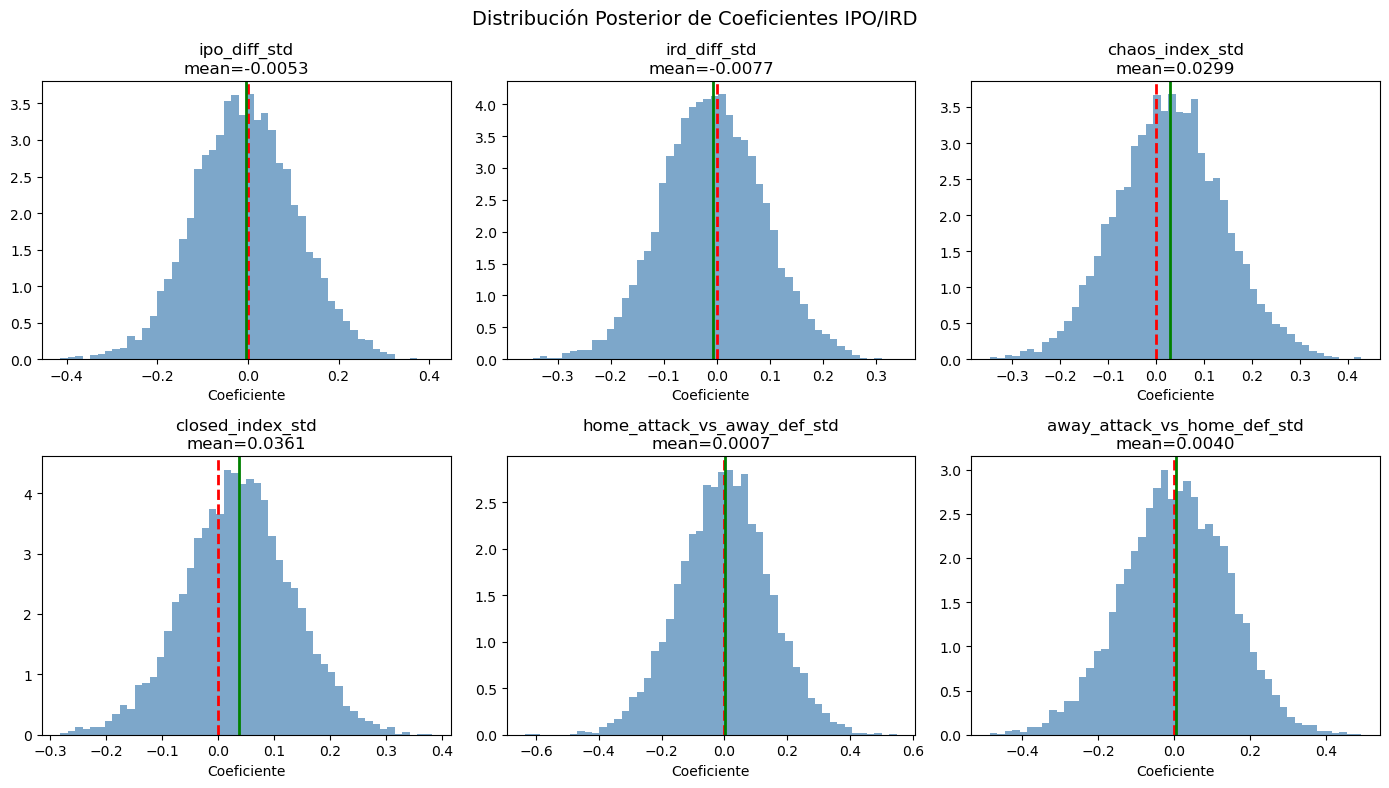

✓ Gráfico guardado: ipo_ird_coefficients.png


In [34]:
# %% [24] Visualización de coeficientes IPO/IRD
"""
VISUALIZACIÓN DE EFECTOS IPO/IRD
"""

if len(ipo_feature_names) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    b_ipo_samples = trace.posterior["b_ipo"].values.reshape(-1, len(ipo_feature_names))
    
    for i, (name, ax) in enumerate(zip(ipo_feature_names, axes)):
        samples = b_ipo_samples[:, i]
        ax.hist(samples, bins=50, density=True, alpha=0.7, color='steelblue')
        ax.axvline(0, color='red', linestyle='--', linewidth=2)
        ax.axvline(samples.mean(), color='green', linestyle='-', linewidth=2)
        ax.set_title(f'{name}\nmean={samples.mean():.4f}')
        ax.set_xlabel('Coeficiente')
    
    # Ocultar ejes vacíos
    for j in range(len(ipo_feature_names), len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Distribución Posterior de Coeficientes IPO/IRD', fontsize=14)
    plt.tight_layout()
    plt.savefig('ipo_ird_coefficients.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Gráfico guardado: ipo_ird_coefficients.png")

In [35]:
# %% [25] Validación en Test Set
"""
VALIDACIÓN DEL MODELO EN TEST SET
"""

def validate_on_test(trace, test_df, teams_df, n_teams, n_features, ipo_feature_names, n_samples=2000):
    """Evalúa el modelo en el test set"""
    
    rng = np.random.default_rng(RANDOM_SEED)
    
    predictions = []
    actuals_home = []
    actuals_away = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Validando"):
        home_name = row['home_team']
        away_name = row['away_team']
        
        try:
            result = predict_shots_match_enhanced(
                trace=trace,
                teams_df=teams_df,
                df_all=df,
                n_teams=n_teams,
                n_features=n_features,
                ipo_feature_names=ipo_feature_names,
                home_name=home_name,
                away_name=away_name,
                total_lines=[],  # No imprimir líneas
                team_lines=[],
                n_draws=n_samples,
                seed=RANDOM_SEED + idx
            )
            
            predictions.append({
                'home_exp': result['home_exp'],
                'away_exp': result['away_exp'],
                'total_exp': result['total_exp']
            })
            actuals_home.append(row['ys1'])
            actuals_away.append(row['ys2'])
            
        except Exception as e:
            print(f"Error en {home_name} vs {away_name}: {e}")
            continue
    
    # Métricas
    pred_home = np.array([p['home_exp'] for p in predictions])
    pred_away = np.array([p['away_exp'] for p in predictions])
    pred_total = np.array([p['total_exp'] for p in predictions])
    
    act_home = np.array(actuals_home)
    act_away = np.array(actuals_away)
    act_total = act_home + act_away
    
    mae_home = np.mean(np.abs(pred_home - act_home))
    mae_away = np.mean(np.abs(pred_away - act_away))
    mae_total = np.mean(np.abs(pred_total - act_total))
    
    print("\n" + "=" * 50)
    print("VALIDACIÓN EN TEST SET")
    print("=" * 50)
    print(f"Partidos evaluados: {len(predictions)}")
    print(f"MAE Home:  {mae_home:.2f}")
    print(f"MAE Away:  {mae_away:.2f}")
    print(f"MAE Total: {mae_total:.2f}")
    
    return {
        'mae_home': mae_home,
        'mae_away': mae_away,
        'mae_total': mae_total,
        'predictions': predictions
    }

# Ejecutar validación (comentar si tarda mucho)
# validation_results = validate_on_test(trace, test, teams, n_teams, n_features, ipo_feature_names)

print("\n✓ Modelo completo. Usa predict_shots_match_enhanced() para predicciones.")









✓ Modelo completo. Usa predict_shots_match_enhanced() para predicciones.
